In [1]:
# imports
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import np_utils
from keras.metrics import CategoricalAccuracy
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import cv2 
import random
import sys
import time
from tqdm.notebook import tqdm

In [ ]:
# Download dataset
!mkdir ~/.kaggle # create a kaggle folder in the root directory
!echo '{"username":"manpabarman","key":"fb51bde6b491583a924e4ec5968d36b0"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [3]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda -p /content/kaggle/

 98% 368M/376M [00:03<00:00, 123MB/s]
100% 376M/376M [00:03<00:00, 122MB/s]


In [ ]:
!unzip /content/kaggle/animal-image-datasetdog-cat-and-panda.zip
!rm -r /content/kaggle/animal-image-datasetdog-cat-and-panda.zip
!rm -r /content/kaggle

In [5]:
# Define the categories and path
categories = ["cats","dogs","panda"]
path = '/content/animals/animals/'

In [6]:
# inspect the shapes of images if they are same or not
shape0 = []
shape1 = []

for category in categories:
  for files in os.listdir(path+category)[:3]:
    img_read = cv2.imread(path+category+'/'+files)
    shape0.append(img_read.shape[0])
    shape1.append(img_read.shape[1])
print(shape0)
print(shape1)


[399, 374, 497, 138, 255, 270, 375, 375, 470]
[399, 500, 399, 186, 255, 259, 500, 500, 500]


In [7]:
# If sizes are differet resize the images
image_data = []
height = 128
width = 128
labels = []

for i, category in enumerate(categories):
  for files in os.listdir(path+category):
    image = cv2.imread(path+category+'/'+files)
    image = cv2.resize(image,(width,height))
    image_data.append(image)
    label = i
    labels.append(label)

In [8]:
# test if the resizing is okay
print(len(labels))
print(len(image_data))
print(image.shape)

3000
3000
(128, 128, 3)


In [9]:
# standerdize the images in the range [0,1]
image_data = np.array(image_data,dtype = "float")/255
labels = np.array(labels)

In [10]:
# Define the model
def build_model(input_size,animal_class):
  input = Input(shape= input_size)
  conv1 = keras.layers.Conv2D(32, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_1")(input)
  max_pool1 = keras.layers.MaxPooling2D(pool_size=2)(conv1)
  conv2 = keras.layers.Conv2D(64, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_2")(max_pool1)
  max_pool2 = keras.layers.MaxPooling2D(pool_size=2)(conv2)
  conv3 = keras.layers.Conv2D(128, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_3")(max_pool2)
  max_pool3 = keras.layers.MaxPooling2D(pool_size=2)(conv3)
  conv4 = keras.layers.Conv2D(256, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_4")(max_pool3)
  max_pool4 = keras.layers.MaxPooling2D(pool_size=2)(conv4)
  dropout_1 = keras.layers.Dropout(0.2)(max_pool4)
  flatten = keras.layers.Flatten()(dropout_1)
  dense_1 =keras.layers.Dense(500,activation="relu")(flatten)
  dropout_2 = keras.layers.Dropout(0.2)(dense_1)
  output =keras.layers.Dense(animal_class,activation="softmax")(dropout_2)
  model = keras.Model(inputs=input, outputs=output)

  return model

#model = build_model(input_size,animal_class)
#model.summary()

In [11]:


# Function to utilize Gradient tape during training
def step(X, y):
  # keep track of our gradients
  with tf.GradientTape() as tape:
		# make a prediction using the model and then calculate the
		# loss
    pred = model(X)
    loss = categorical_crossentropy(y, pred)
    total_loss = tf.reduce_sum(loss)
	# calculate the gradients using our tape and then update the
	# model weights
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  
  # Update training metric.
  train_acc_metric.update_state(y,pred)
  return total_loss.numpy()

In [12]:
# Initialize
input_size = image.shape
epochs = 50
batch_size = 100
lr_ = 1e-3
animal_class = 3

In [13]:
# split the data into train and test set(80%-train and 20%-test)
(trainX, testX, trainY, testY) = train_test_split(image_data, labels, test_size=0.2, random_state=42)

#one-hot encode the labels
trainY = np_utils.to_categorical(trainY, animal_class)
testY= np_utils.to_categorical(testY, animal_class)

#check the shapes 
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2400, 128, 128, 3)
(600, 128, 128, 3)
(2400, 3)
(600, 3)


In [14]:
# build our model
model = build_model(input_size,animal_class)
opt = Adam(lr=lr_, decay=lr_ / epochs)

In [15]:
# prepare the metrics
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [16]:
def display_metrics(testX,testY):
    #val_dataset = tf.data.Dataset.from_tensor_slices((testX, testY))
    #val_dataset = val_dataset.batch(100) 

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    #for testX,testY in val_dataset:
    val_logits = model(testX, training=False)
    # Update val metrics
    val_acc_metric.update_state(testY, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))



In [17]:
# train our model 
num_of_batches = int(trainX.shape[0] / batch_size)

for epoch in range(0, epochs):
    print("[INFO] starting epoch {}/{}...".format(
        epoch + 1,epochs), end=" ")
    sys.stdout.flush()
    epochStart = time.time()
    t =  tqdm(range(num_of_batches))
    for i in t:
        start = i * batch_size
        end = start + batch_size
        loss = step(trainX[start:end], trainY[start:end])
        message = "total loss: {}".format(str(loss))
        t.set_postfix_str(message)
    display_metrics(testX,testY)
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("Time elapsed = {:.4} minutes".format(elapsed)) # {:.4} is for output padding

[INFO] starting epoch 1/50... 


Training acc over epoch: 0.4437
Validation acc: 0.5183
Time elapsed = 0.1889 minutes
[INFO] starting epoch 2/50... 


Training acc over epoch: 0.5813
Validation acc: 0.6217
Time elapsed = 0.05473 minutes
[INFO] starting epoch 3/50... 


Training acc over epoch: 0.6058
Validation acc: 0.6167
Time elapsed = 0.05603 minutes
[INFO] starting epoch 4/50... 


Training acc over epoch: 0.6508
Validation acc: 0.6800
Time elapsed = 0.05594 minutes
[INFO] starting epoch 5/50... 


Training acc over epoch: 0.6750
Validation acc: 0.7017
Time elapsed = 0.05696 minutes
[INFO] starting epoch 6/50... 


Training acc over epoch: 0.7092
Validation acc: 0.6783
Time elapsed = 0.05644 minutes
[INFO] starting epoch 7/50... 


Training acc over epoch: 0.7437
Validation acc: 0.6733
Time elapsed = 0.05619 minutes
[INFO] starting epoch 8/50... 


Training acc over epoch: 0.7725
Validation acc: 0.7133
Time elapsed = 0.05638 minutes
[INFO] starting epoch 9/50... 


Training acc over epoch: 0.7946
Validation acc: 0.7117
Time elapsed = 0.05712 minutes
[INFO] starting epoch 10/50... 


Training acc over epoch: 0.8029
Validation acc: 0.6500
Time elapsed = 0.05665 minutes
[INFO] starting epoch 11/50... 


Training acc over epoch: 0.8154
Validation acc: 0.6633
Time elapsed = 0.05694 minutes
[INFO] starting epoch 12/50... 


Training acc over epoch: 0.8221
Validation acc: 0.6783
Time elapsed = 0.05579 minutes
[INFO] starting epoch 13/50... 


Training acc over epoch: 0.8454
Validation acc: 0.7300
Time elapsed = 0.05676 minutes
[INFO] starting epoch 14/50... 


Training acc over epoch: 0.8833
Validation acc: 0.7000
Time elapsed = 0.05638 minutes
[INFO] starting epoch 15/50... 


Training acc over epoch: 0.9275
Validation acc: 0.7433
Time elapsed = 0.05757 minutes
[INFO] starting epoch 16/50... 


Training acc over epoch: 0.9200
Validation acc: 0.7400
Time elapsed = 0.05728 minutes
[INFO] starting epoch 17/50... 


Training acc over epoch: 0.9087
Validation acc: 0.6650
Time elapsed = 0.05693 minutes
[INFO] starting epoch 18/50... 


Training acc over epoch: 0.9404
Validation acc: 0.6600
Time elapsed = 0.05748 minutes
[INFO] starting epoch 19/50... 


Training acc over epoch: 0.9529
Validation acc: 0.6450
Time elapsed = 0.05735 minutes
[INFO] starting epoch 20/50... 


Training acc over epoch: 0.9354
Validation acc: 0.6817
Time elapsed = 0.05777 minutes
[INFO] starting epoch 21/50... 


Training acc over epoch: 0.9396
Validation acc: 0.6900
Time elapsed = 0.05763 minutes
[INFO] starting epoch 22/50... 


Training acc over epoch: 0.9588
Validation acc: 0.7233
Time elapsed = 0.05735 minutes
[INFO] starting epoch 23/50... 


Training acc over epoch: 0.9683
Validation acc: 0.7317
Time elapsed = 0.0574 minutes
[INFO] starting epoch 24/50... 


Training acc over epoch: 0.9721
Validation acc: 0.7117
Time elapsed = 0.05815 minutes
[INFO] starting epoch 25/50... 


Training acc over epoch: 0.9817
Validation acc: 0.6967
Time elapsed = 0.05685 minutes
[INFO] starting epoch 26/50... 


Training acc over epoch: 0.9796
Validation acc: 0.7067
Time elapsed = 0.05765 minutes
[INFO] starting epoch 27/50... 


Training acc over epoch: 0.9754
Validation acc: 0.7050
Time elapsed = 0.05785 minutes
[INFO] starting epoch 28/50... 


Training acc over epoch: 0.9758
Validation acc: 0.7217
Time elapsed = 0.05805 minutes
[INFO] starting epoch 29/50... 


Training acc over epoch: 0.9833
Validation acc: 0.7317
Time elapsed = 0.05806 minutes
[INFO] starting epoch 30/50... 


Training acc over epoch: 0.9954
Validation acc: 0.7250
Time elapsed = 0.05816 minutes
[INFO] starting epoch 31/50... 


Training acc over epoch: 0.9954
Validation acc: 0.7350
Time elapsed = 0.05774 minutes
[INFO] starting epoch 32/50... 


Training acc over epoch: 0.9992
Validation acc: 0.7333
Time elapsed = 0.0582 minutes
[INFO] starting epoch 33/50... 


Training acc over epoch: 0.9987
Validation acc: 0.7400
Time elapsed = 0.05852 minutes
[INFO] starting epoch 34/50... 


Training acc over epoch: 0.9967
Validation acc: 0.7400
Time elapsed = 0.0592 minutes
[INFO] starting epoch 35/50... 


Training acc over epoch: 0.9987
Validation acc: 0.7300
Time elapsed = 0.0584 minutes
[INFO] starting epoch 36/50... 


Training acc over epoch: 0.9992
Validation acc: 0.7400
Time elapsed = 0.05863 minutes
[INFO] starting epoch 37/50... 


Training acc over epoch: 0.9987
Validation acc: 0.7350
Time elapsed = 0.05945 minutes
[INFO] starting epoch 38/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7233
Time elapsed = 0.0588 minutes
[INFO] starting epoch 39/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.05851 minutes
[INFO] starting epoch 40/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7350
Time elapsed = 0.05892 minutes
[INFO] starting epoch 41/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.0592 minutes
[INFO] starting epoch 42/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.05956 minutes
[INFO] starting epoch 43/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.05976 minutes
[INFO] starting epoch 44/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.05999 minutes
[INFO] starting epoch 45/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7317
Time elapsed = 0.05955 minutes
[INFO] starting epoch 46/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7300
Time elapsed = 0.06047 minutes
[INFO] starting epoch 47/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7300
Time elapsed = 0.06004 minutes
[INFO] starting epoch 48/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7300
Time elapsed = 0.0599 minutes
[INFO] starting epoch 49/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7300
Time elapsed = 0.05913 minutes
[INFO] starting epoch 50/50... 


Training acc over epoch: 1.0000
Validation acc: 0.7283
Time elapsed = 0.05974 minutes


In [18]:
# calculate the accuracy against the real and predicted output
model.compile(optimizer=opt, loss=categorical_crossentropy,metrics=["acc"])
(loss, acc) = model.evaluate(testX, testY)
print("[INFO] test accuracy: {:.4f}".format(acc))

19/19 [==============================] - 1s 15ms/step - loss: 2.6084 - acc: 0.7353
[INFO] test accuracy: 0.7283


In [24]:
#test my model
img = cv2.imread('/content/animals/images/dog.jpg')
img = cv2.resize(img,(width,height))
img = np.expand_dims(img,axis = 0)
img.shape
out_array = model.predict(img)
categories[out_array.argmax(axis=1)[-1]]

'dogs'

'cats'

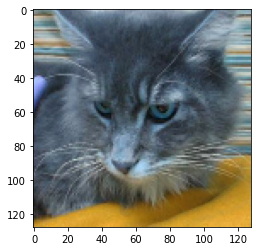

In [20]:
idx = random.randint(0, len(image_data))
rand_img = image_data[idx]
plt.imshow(rand_img)
rand_img = np.expand_dims(rand_img,axis = 0)
out_array = model.predict(rand_img)
categories[out_array.argmax(axis=1)[-1]]